In [90]:
import math
import matplotlib
import numpy as np
import pandas as pd
import time

from datetime import date, datetime, time, timedelta
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# https://zhuanlan.zhihu.com/p/56507515
# https://zhuanlan.zhihu.com/p/410655154
# https://zhuanlan.zhihu.com/p/21275919

In [176]:
src_path = 'indexProcessed.csv'
test_size = 0.1               # proportion of dataset to be used as test set
cv_size = 0.2                   # proportion of dataset to be used as cross-validation set
Nmax = 2                        # for feature at day t, we use lags from t-1, t-2, ..., t-N as features
                                # Nmax is the maximum N we are going to test
fontsize = 14
ticklabelsize = 14

In [177]:
df = pd.read_csv(src_path, sep = ",")
# df = df.drop(df.columns[[0]], axis = 1)
del df['Index']
display(df)

,Date,Open,High,Low,Close,Adj Close,Volume,CloseUSD
0,1986-12-31,2568.300049,2568.300049,2568.300049,2568.300049,2568.300049,0.0,333.879006
1,1987-01-02,2540.100098,2540.100098,2540.100098,2540.100098,2540.100098,0.0,330.213013
2,1987-01-05,2552.399902,2552.399902,2552.399902,2552.399902,2552.399902,0.0,331.811987
3,1987-01-06,2583.899902,2583.899902,2583.899902,2583.899902,2583.899902,0.0,335.906987
4,1987-01-07,2607.100098,2607.100098,2607.100098,2607.100098,2607.100098,0.0,338.923013
...,...,...,...,...,...,...,...,...
55790,2003-11-26,590.140015,594.909973,588.250000,588.770020,588.770020,0.0,718.299424
55791,2003-11-27,591.659973,592.409973,589.070007,591.340027,591.340027,0.0,721.434833
55792,2003-11-28,591.690002,593.010010,585.289978,589.349976,589.349976,0.0,719.006971
55793,2003-12-01,593.619995,599.679993,592.650024,599.260010,599.260010,0.0,731.097212


In [178]:
# Convert Date column to datetime
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')

# Change all column headings to be lower case, and remove spacing
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]

# Get month of each sample
df['month'] = df['date'].dt.month

# Sort by datetime
df.sort_values(by='date', inplace=True, ascending=True)

df.head(10)

/tmp/ipykernel_84/2103356123.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')


,date,open,high,low,close,adj_close,volume,closeusd,month
40920,1965-01-05,1257.719971,1257.719971,1257.719971,1257.719971,1257.719971,0.0,12.577200,1
40921,1965-01-06,1263.989990,1263.989990,1263.989990,1263.989990,1263.989990,0.0,12.639900,1
40922,1965-01-07,1274.270020,1274.270020,1274.270020,1274.270020,1274.270020,0.0,12.742700,1
40923,1965-01-08,1286.430054,1286.430054,1286.430054,1286.430054,1286.430054,0.0,12.864301,1
40924,1965-01-12,1288.540039,1288.540039,1288.540039,1288.540039,1288.540039,0.0,12.885400,1
40925,1965-01-13,1281.670044,1281.670044,1281.670044,1281.670044,1281.670044,0.0,12.816700,1
40926,1965-01-14,1289.500000,1289.500000,1289.500000,1289.500000,1289.500000,0.0,12.895000,1
40927,1965-01-18,1271.680054,1271.680054,1271.680054,1271.680054,1271.680054,0.0,12.716801,1
40928,1965-01-19,1270.339966,1270.339966,1270.339966,1270.339966,1270.339966,0.0,12.703400,1
40929,1965-01-20,1268.880005,1268.880005,1268.880005,1268.880005,1268.880005,0.0,12.688800,1


Text(0.5, 0, 'date')

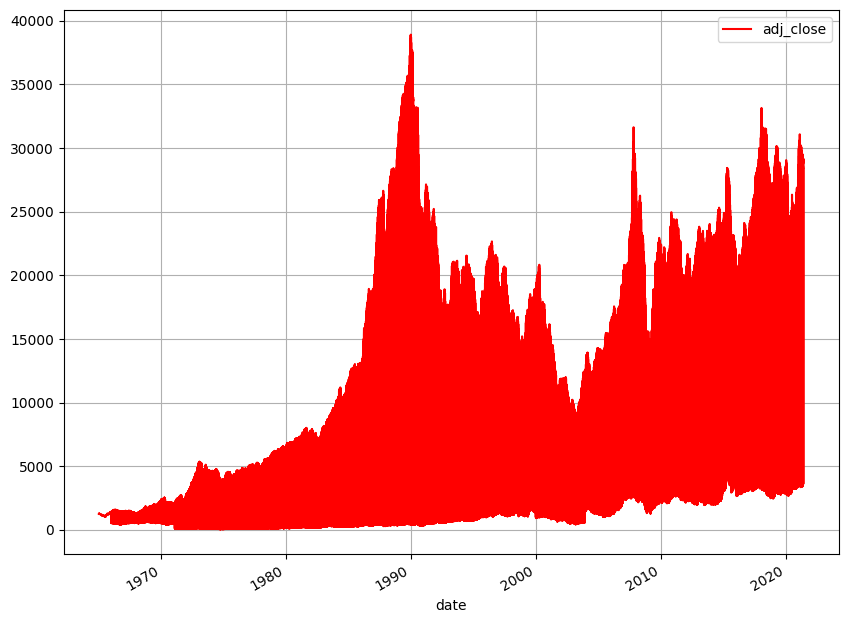

In [179]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = df.plot(x = 'date', y = 'adj_close', style = 'r-', grid = True)
ax.set_xlabel("date")
# df.plot(x = 'date', y = 'adj_close', marker = ',', markevery = 10, color = 'r', ls = '-', lw = 2)

In [180]:
# Get sizes of each of the datasets
num_cv, num_test = int(cv_size*len(df)), int(test_size*len(df))
num_train = len(df) - num_cv - num_test

print("total_num = " + str(len(df)) )
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train: num_train + num_cv]
train_cv = df[:num_train + num_cv]
test = df[num_train + num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

total_num = 55795
num_train = 39057
num_cv = 11159
num_test = 5579
train.shape = (39057, 9)
cv.shape = (11159, 9)
train_cv.shape = (50216, 9)
test.shape = (5579, 9)


Text(0, 0.5, 'USD')

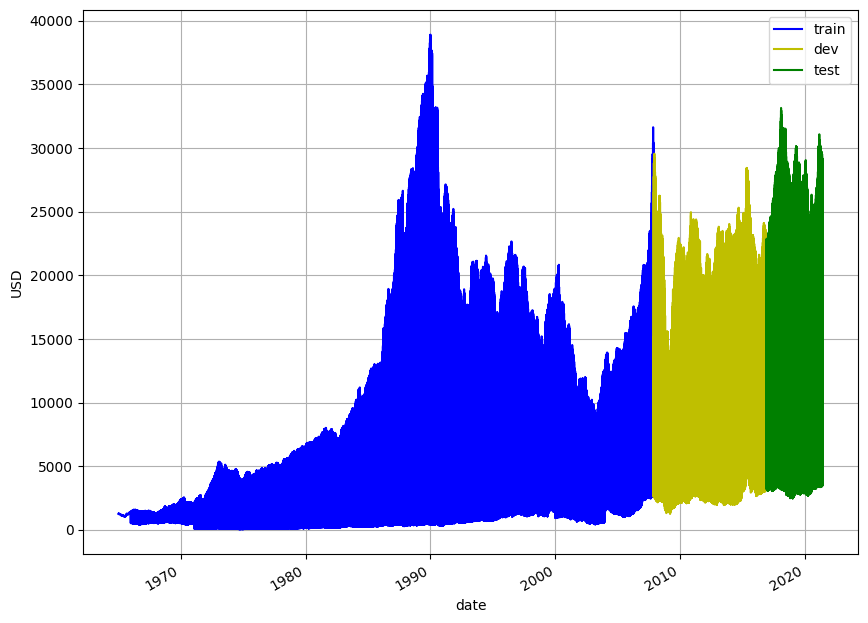

In [181]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 10, 8 # width 10, height 8

ax = train.plot(x = 'date', y = 'adj_close', style = 'b-', grid = True)
ax = cv.plot(x = 'date', y = 'adj_close', style = 'y-', grid = True, ax = ax)
ax = test.plot(x = 'date', y = 'adj_close', style = 'g-', grid = True, ax = ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

In [211]:
# X_train,Y_train = df['date'][:num_train], df['adj_close'][:num_train]
# X_test,Y_test = df['date'][num_train:], df['adj_close'][num_train:]
X_train, Y_train = df[:num_train], df[:num_train].adj_close
X_test, Y_test = df[num_train:], df[num_train:].adj_close
# Y_train = df.pop('adj_close')
# X_train = df.pop('date')

date_val = X_test['date']
del X_train['adj_close']
del X_train['date']
del X_train['closeusd']
del X_test['adj_close']
del X_test['date']
del X_test['closeusd']

# X_train = X_train['open'].values.reshape(-1, 1)
# X_test = X_test['open'].values.reshape(-1, 1)

mean = Y_train.mean()
print(mean)
Y_train = Y_train.fillna(mean, inplace=False) 

mean = X_train.mean()
X_train = X_train.fillna(mean, inplace=False) 

# mean = X_test.mean()
# X_test = X_test.fillna(mean, inplace=False) 

# mean = Y_test.mean()
# Y_test = Y_test.fillna(mean, inplace=False) 
# # X_train = X_train.values.reshape(-1, 1)

print(X_train, Y_train)
# print(X_test, Y_test)

5575.350928638724
               open          high           low         close        volume  \
40920   1257.719971   1257.719971   1257.719971   1257.719971  0.000000e+00   
40921   1263.989990   1263.989990   1263.989990   1263.989990  0.000000e+00   
40922   1274.270020   1274.270020   1274.270020   1274.270020  0.000000e+00   
40923   1286.430054   1286.430054   1286.430054   1286.430054  0.000000e+00   
40924   1288.540039   1288.540039   1288.540039   1288.540039  0.000000e+00   
...             ...           ...           ...           ...           ...   
5163   28787.400390  29175.259770  28622.970700  29166.009770  2.952928e+09   
19031   9861.009766   9947.719727   9790.990234   9809.150391  4.031470e+09   
31721   2698.030029   2698.350098   2636.320068   2644.320068  2.420260e+09   
51485  15311.379880  15504.990230  15287.259770  15499.559570  1.390000e+08   
37631   5391.017090   5453.740234   5338.904785   5365.267090  4.780000e+04   

       month  
40920      1  
409

In [212]:
# from sklearn import linear_model
# reg = linear_model.Ridge(alpha=.5)
# # score = get_score(X_train, y_train)
# reg.fit(X_train, Y_train)
# reg.coef_
# reg.intercept_

from sklearn import linear_model
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train, Y_train)
regr.coef_
regr.intercept_

-7.457856554538012e-11

In [216]:
# from sklearn.metrics import median_absolute_error

# y_pred = reg.predict(X_train)

# mae = median_absolute_error(Y_train, y_pred)
# string_score = f"MAE on training set: {mae:.2f} $/hour"
# y_pred = reg.predict(X_test)
# mae = median_absolute_error(Y_test, y_pred)
# string_score += f"\nMAE on testing set: {mae:.2f} $/hour"

Y_pred = regr.predict(X_test)
print(Y_pred, len(Y_pred))

from sklearn.metrics import mean_squared_error, r2_score
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(Y_test, Y_pred))

[28751.21094   9652.519531  2618.51001  ... 28814.33984  28946.14063
 29058.10938 ] 16738
Coefficients: 
 [-1.38667474e-12  1.26616469e-12  8.79890175e-14  1.00000000e+00
  3.34005304e-19 -3.17017602e-18]
Mean squared error: 0.00
Coefficient of determination: 1.00


16738 16738


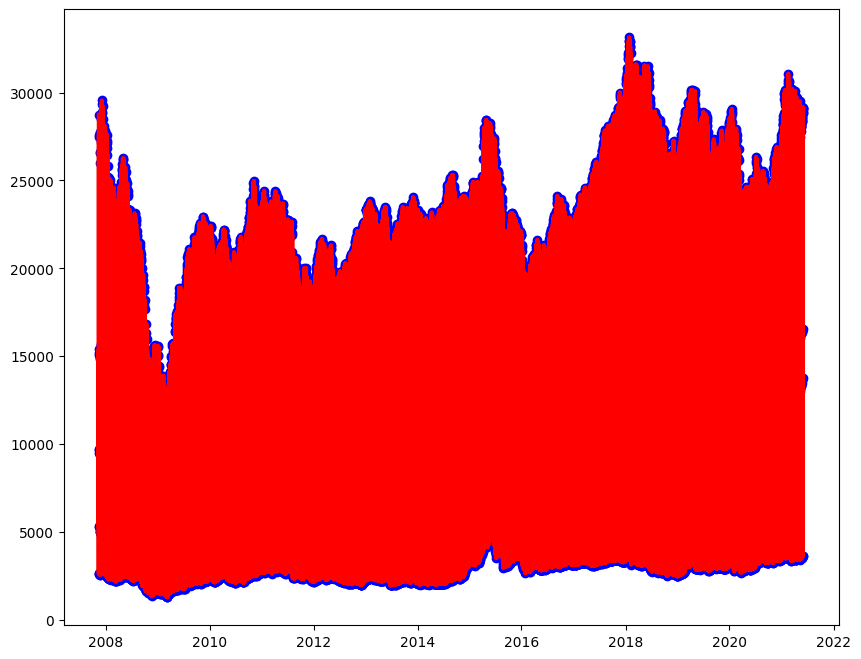

In [214]:
print(len(Y_pred), len(Y_test))
plt.scatter(date_val, Y_test, color="blue")
plt.plot(date_val, Y_pred, color="red", linewidth = 3)
plt.show()

In [215]:
from sklearn.metrics import explained_variance_score
explained_variance_score(Y_pred, Y_test)

times = 0
diff = 0
print(len(Y_pred))
for i in Y_test:
    if int(i) != int(Y_pred[times]):
        print("different", i, Y_pred[times])
        diff += 1
    times += 1
print(diff, diff / len(Y_pred))

16738
different 10435.0 10434.999999999944
different 10204.0 10203.999999999967
different 3135.0 3134.9999999999
different 8382.0 8381.999999999987
different 8851.0 8850.99999999994
different 8755.0 8754.99999999999
different 9110.0 9109.999999999964
different 15124.0 15123.999999999854
different 15095.0 15094.999999999845
different 19437.0 19436.999999999905
different 17891.0 17890.999999999847
different 15859.0 15858.999999999942
different 3023.0 3022.9999999999054
different 16840.0 16839.999999999978
different 3277.0 3276.9999999999272
different 19843.0 19842.999999999825
different 22868.0 22867.999999999825
different 22199.0 22198.99999999981
different 20649.0 20648.99999999981
different 22200.0 22199.99999999978
different 21032.0 21031.99999999989
different 21124.0 21123.999999999913
different 2880.0 2879.9999999999227
different 19262.0 19261.99999999984
different 21710.0 21709.99999999979
different 29854.0 29853.999999999964
26 0.0015533516549169554


In [152]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(regr, X_test, Y_test, cv=5)
print(scores)

[1. 1. 1. 1. 1.]
